In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
# Load the preprocessed data
data = pd.read_csv('../data/reliance_stock_data_processed.csv', parse_dates=['Date'])

In [18]:
# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Check the first row of the dataset
print(data.head(1))

                   Open         High          Low   Close  Adj Close   Volume  \
Date                                                                            
2023-09-26  2338.550049  2350.199951  2335.600098  2342.5     2342.5  5043891   

                SMA_10       SMA_30       EMA_10       EMA_30  Daily_Return  \
Date                                                                          
2023-09-26  2402.23501  2449.963338  2387.537671  2443.089274      0.000876   

            Volatility  
Date                    
2023-09-26    0.008325  


# SARIMA

In [19]:
# Train the SARIMA model on the 'Close' column
sarima_model = SARIMAX(data['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)

d:\Anaconda3\envs\stockPrediciton\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda3\envs\stockPrediciton\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [20]:
# Make predictions with SARIMA (let's predict the last 30 data points for evaluation)
sarima_predictions = sarima_result.predict(start=len(data) - 30, end=len(data) - 1)

In [21]:
# Evaluate the SARIMA model
sarima_rmse = mean_squared_error(data['Close'].iloc[-30:], sarima_predictions, squared=False)
sarima_mae = mean_absolute_error(data['Close'].iloc[-30:], sarima_predictions)
sarima_r2 = r2_score(data['Close'].iloc[-30:], sarima_predictions)

d:\Anaconda3\envs\stockPrediciton\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# Print the evaluation metrics
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"SARIMA MAE: {sarima_mae}")
print(f"SARIMA R²: {sarima_r2}")

SARIMA RMSE: 40.310368463770594
SARIMA MAE: 29.326272152090315
SARIMA R²: 0.836599937877482


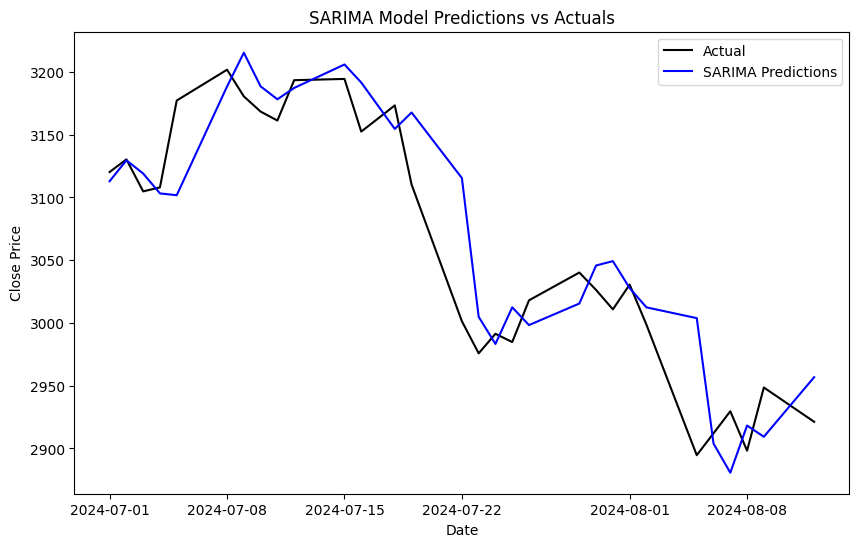

In [24]:
# Optionally, plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index[-30:], data['Close'].iloc[-30:], label='Actual', color='black')
plt.plot(data.index[-30:], sarima_predictions, label='SARIMA Predictions', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SARIMA Model Predictions vs Actuals')
plt.legend()
plt.show()

# Prophet

09:08:14 - cmdstanpy - INFO - Chain [1] start processing
09:08:14 - cmdstanpy - INFO - Chain [1] done processing
d:\Anaconda3\envs\stockPrediciton\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Prophet RMSE: 14.624964961551681
Prophet MAE: 11.0312337553369
Prophet R²: 0.9970744992707639


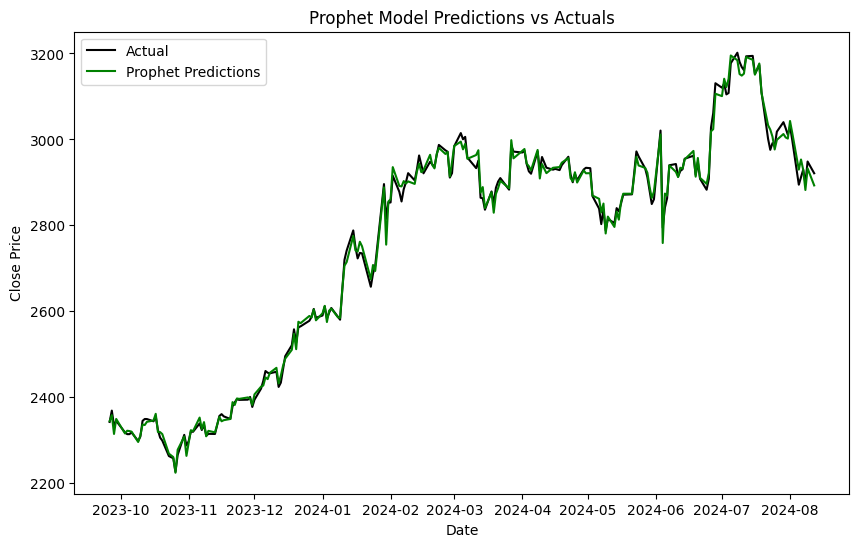

In [48]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import plotly.graph_objs as go
import pandas as pd
import pickle

# Load the dataset
data = pd.read_csv('../data/reliance_stock_data_processed.csv', parse_dates=['Date'])

# Ensure 'Date' is a datetime column and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Load the trained Prophet model
with open('prophet_model.pkl', 'rb') as f:
    prophet_model = pickle.load(f)

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define the layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Reliance Stock Analysis Dashboard"), className="text-center mb-4")
    ]),
    
    dbc.Row([
        dbc.Col([
            dcc.DatePickerRange(
                id='date-picker',
                min_date_allowed=data['Date'].min(),
                max_date_allowed=data['Date'].max(),
                start_date=data['Date'].min(),
                end_date=data['Date'].max(),
                display_format='YYYY-MM-DD'
            )
        ], width=6),
        dbc.Col([
            dcc.Dropdown(
                id='sma-ema-dropdown',
                options=[
                    {'label': 'SMA 10', 'value': 'SMA_10'},
                    {'label': 'SMA 30', 'value': 'SMA_30'},
                    {'label': 'EMA 10', 'value': 'EMA_10'},
                    {'label': 'EMA 30', 'value': 'EMA_30'}
                ],
                value=['SMA_10', 'SMA_30'],
                multi=True
            )
        ], width=6)
    ]),

    dbc.Row([
        dbc.Col([
            dcc.Graph(id='price-chart')
        ], width=12)
    ]),

    dbc.Row([
        dbc.Col([
            dcc.Graph(id='volume-chart')
        ], width=12)
    ]),

    dbc.Row([
        dbc.Col([
            dcc.Graph(id='volatility-chart')
        ], width=6),
        dbc.Col([
            dcc.Graph(id='daily-return-histogram')
        ], width=6)
    ]),

    dbc.Row([
        dbc.Col([
            dcc.Graph(id='correlation-heatmap')
        ], width=12)
    ]),

    dbc.Row([
        dbc.Col([
            dcc.Graph(id='forecast-chart')
        ], width=12)
    ])
])

# Define callbacks to update charts based on user input
@app.callback(
    [Output('price-chart', 'figure'),
     Output('volume-chart', 'figure'),
     Output('volatility-chart', 'figure'),
     Output('daily-return-histogram', 'figure'),
     Output('correlation-heatmap', 'figure'),
     Output('forecast-chart', 'figure')],
    [Input('date-picker', 'start_date'),
     Input('date-picker', 'end_date'),
     Input('sma-ema-dropdown', 'value')]
)
def update_charts(start_date, end_date, selected_indicators):
    filtered_data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Price chart with SMA/EMA
    price_chart = go.Figure()
    price_chart.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['Close'], mode='lines', name='Close Price'))
    for indicator in selected_indicators:
        price_chart.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data[indicator], mode='lines', name=indicator))

    # Volume chart
    volume_chart = go.Figure(go.Bar(x=filtered_data.index, y=filtered_data['Volume'], name='Volume'))

    # Volatility chart
    volatility_chart = go.Figure(go.Scatter(x=filtered_data.index, y=filtered_data['Volatility'], mode='lines', name='Volatility'))

    # Daily return histogram
    daily_return_histogram = go.Figure(go.Histogram(x=filtered_data['Daily_Return'], nbinsx=50, name='Daily Return'))

    # Correlation heatmap
    corr_matrix = filtered_data[['Close', 'Volume', 'SMA_10', 'SMA_30', 'EMA_10', 'EMA_30', 'Daily_Return', 'Volatility']].corr()
    correlation_heatmap = go.Figure(go.Heatmap(z=corr_matrix.values, x=corr_matrix.columns, y=corr_matrix.columns, colorscale='Viridis'))

    # Forecast vs Actual (using Prophet's prediction)
    future = pd.DataFrame({
        'ds': pd.date_range(start=start_date, end=end_date),
        'Volume': filtered_data['Volume'].reindex(pd.date_range(start=start_date, end=end_date)).values,
        'SMA_10': filtered_data['SMA_10'].reindex(pd.date_range(start=start_date, end=end_date)).values,
        'SMA_30': filtered_data['SMA_30'].reindex(pd.date_range(start=start_date, end=end_date)).values,
        'EMA_10': filtered_data['EMA_10'].reindex(pd.date_range(start=start_date, end=end_date)).values,
        'EMA_30': filtered_data['EMA_30'].reindex(pd.date_range(start=start_date, end=end_date)).values,
        'Daily_Return': filtered_data['Daily_Return'].reindex(pd.date_range(start=start_date, end=end_date)).values,
        'Volatility': filtered_data['Volatility'].reindex(pd.date_range(start=start_date, end=end_date)).values
    })

    forecast = prophet_model.predict(future)

    forecast_chart = go.Figure()
    forecast_chart.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['Close'], mode='lines', name='Actual'))
    forecast_chart.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Prophet Forecast'))

    return price_chart, volume_chart, volatility_chart, daily_return_histogram, correlation_heatmap, forecast_chart

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


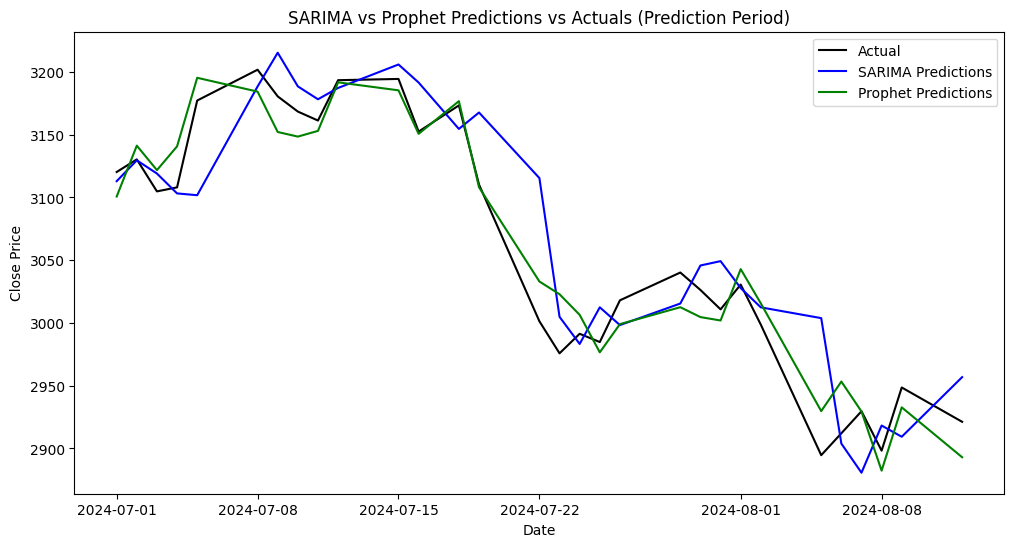

In [56]:
# Define the prediction period (last 30 days, same as SARIMA)
prediction_dates = data.index[-len(sarima_predictions):]

# Select the last 30 days of Prophet predictions to match SARIMA
prophet_predictions_aligned = prophet_predictions[-len(sarima_predictions):]

# Plot the actual values only for the prediction period
plt.figure(figsize=(12, 6))
plt.plot(prediction_dates, data['Close'].iloc[-len(sarima_predictions):], label='Actual', color='black')

# Plot the SARIMA predictions
plt.plot(prediction_dates, sarima_predictions, label='SARIMA Predictions', color='blue')

# Plot the aligned Prophet predictions
plt.plot(prediction_dates, prophet_predictions_aligned, label='Prophet Predictions', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SARIMA vs Prophet Predictions vs Actuals (Prediction Period)')
plt.legend()
plt.show()


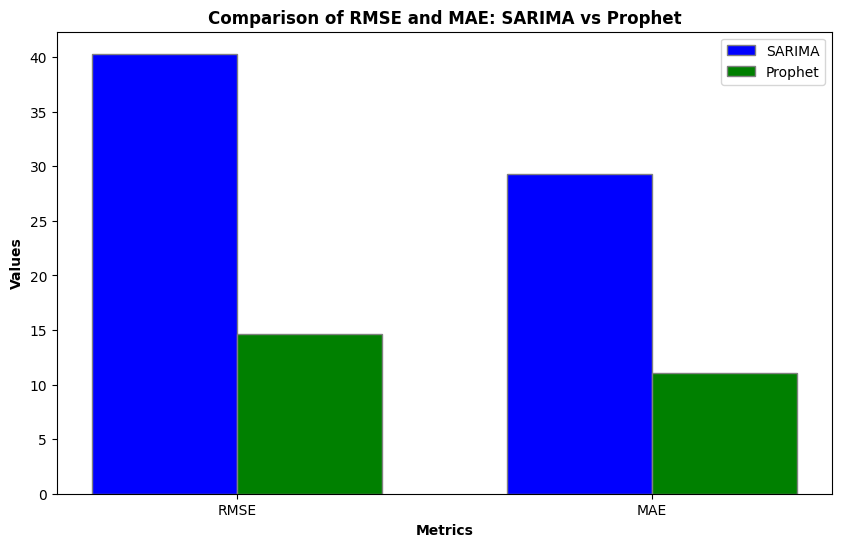

In [64]:
# Collect the metrics in lists
sarima_metrics = [sarima_rmse, sarima_mae]
prophet_metrics = [prophet_rmse, prophet_mae]
metrics_names = ['RMSE', 'MAE']

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
r1 = np.arange(len(metrics_names))
r2 = [x + bar_width for x in r1]

# Create the bar plot for RMSE and MAE
plt.figure(figsize=(10, 6))
plt.bar(r1, sarima_metrics, color='blue', width=bar_width, edgecolor='grey', label='SARIMA')
plt.bar(r2, prophet_metrics, color='green', width=bar_width, edgecolor='grey', label='Prophet')

# Add labels
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Values', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(metrics_names))], metrics_names)
plt.title('Comparison of RMSE and MAE: SARIMA vs Prophet', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()


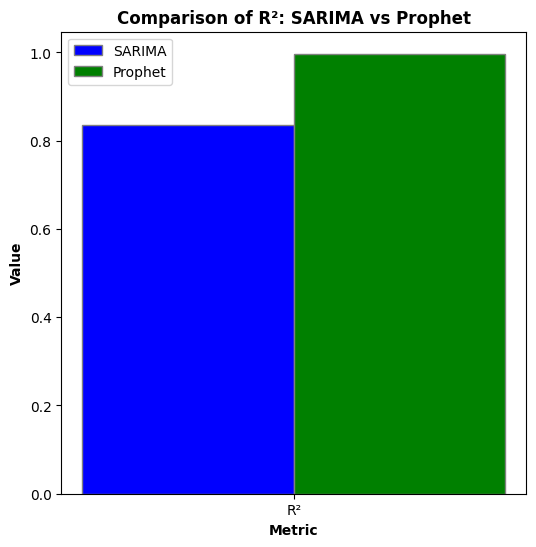

In [65]:
# Collect the R² metrics in lists
sarima_r2_metric = [sarima_r2]
prophet_r2_metric = [prophet_r2]
r2_metrics_names = ['R²']

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
r1 = np.arange(len(r2_metrics_names))
r2 = [x + bar_width for x in r1]

# Create the bar plot for R²
plt.figure(figsize=(6, 6))
plt.bar(r1, sarima_r2_metric, color='blue', width=bar_width, edgecolor='grey', label='SARIMA')
plt.bar(r2, prophet_r2_metric, color='green', width=bar_width, edgecolor='grey', label='Prophet')

# Add labels
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(r2_metrics_names))], r2_metrics_names)
plt.title('Comparison of R²: SARIMA vs Prophet', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()


In [67]:
import pickle
import os

# Define the path to save the model in the root directory
model_path = os.path.join('..', 'prophet_model.pkl')

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump(prophet_model, f)
